# Modelling #1 LogisticReg + HyperOpt

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import json
import numpy as np
import pandas as pd

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-16 13:41:15.794 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [3]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [7]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [8]:
train_data.shape

(12303, 230)

In [12]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

PCA

In [19]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

pca_object = PCA(n_components=0.90)
pca = pca_object.fit_transform(train_data_scaled)
pca_scaled = scaler.fit_transform(pca)

explained_variance_ratio = pca_object.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
n_components = pca_object.n_components_

In [20]:
train_data_reduced = pd.DataFrame(pca, columns=[f"PC{i+1}" for i in range(n_components)], index=train_data.index)
train_data_reduced.shape

(12303, 97)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_data_reduced, train_scores_1c, train_size=0.8, random_state=42)

HyperOpt

In [27]:
space = {
    'C': hp.loguniform('C', -4, 4),  # Regularization strength (log scale: 1e-4 to 1e4)
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0),  # ElasticNet mixing ratio
}

In [30]:
n_splits = 5

def objective(params):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=params['C'],
            l1_ratio=params['l1_ratio'],
            max_iter=2000,
            random_state=42
        )

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_valid_fold)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}

In [31]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  
            trials=trials)

print("Best hyperparameters:", best)

  2%|▏         | 2/100 [01:35<1:17:47, 47.63s/trial, best loss: 0.5043700219252065]


KeyboardInterrupt: 

In [13]:
for trial in trials.trials:
    print(trial['result']['loss'], trial['misc']['vals'])

0.5051827204820272 {'C': [0.04843068577432974], 'l1_ratio': [0.5930218050385194]}
0.5050809912921465 {'C': [8.951345737765108], 'l1_ratio': [0.363593110257706]}
0.5050809912921465 {'C': [11.328138290276941], 'l1_ratio': [0.7781186542373086]}
0.5050809912921465 {'C': [6.898293123608991], 'l1_ratio': [0.6791987203787652]}
0.5050809912921465 {'C': [5.895225534179765], 'l1_ratio': [0.10846706651779348]}
0.5050809912921465 {'C': [53.268933662583436], 'l1_ratio': [0.6851135887819848]}
0.5050809912921465 {'C': [1.9379272114589032], 'l1_ratio': [0.0075800146799198664]}
0.5050808881185259 {'C': [0.44066392298601487], 'l1_ratio': [0.19688650747535674]}
0.5050809912921465 {'C': [40.95606745074332], 'l1_ratio': [0.5216542196688265]}
0.5049793652758863 {'C': [2.879938420309913], 'l1_ratio': [0.9980477697132502]}
0.5049793652758863 {'C': [2.5745970371455598], 'l1_ratio': [0.487870866387936]}
0.5050809912921465 {'C': [9.288474271637398], 'l1_ratio': [0.8883329927351235]}
0.505487289009946 {'C': [0.69

In [14]:
# Convert NumPy types to native Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)  
    elif isinstance(obj, np.floating):
        return float(obj)  
    elif isinstance(obj, list):  
        return [convert_numpy(i) for i in obj]  
    elif isinstance(obj, dict):  
        return {key: convert_numpy(value) for key, value in obj.items()}  
    else:
        return obj

results_with_params = [
    {
        **convert_numpy(trial['result']),
        'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
    }
    for trial in trials.trials
]

with open('opt_lr2.json', 'w') as f:
    json.dump(results_with_params, f, indent=4)

print("Optimization results saved to 'opt_lr2.json'")


Optimization results saved to 'opt_lr2.json'


In [17]:
with open("opt_lr2.json", "r") as f:
    results_with_params = json.load(f)

print("All results:")
for trial in results_with_params:
    print(trial)

All results:
{'loss': 0.5051827204820272, 'status': 'ok', 'params': {'C': 0.04843068577432974, 'l1_ratio': 0.5930218050385194}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 8.951345737765108, 'l1_ratio': 0.363593110257706}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 11.328138290276941, 'l1_ratio': 0.7781186542373086}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 6.898293123608991, 'l1_ratio': 0.6791987203787652}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 5.895225534179765, 'l1_ratio': 0.10846706651779348}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 53.268933662583436, 'l1_ratio': 0.6851135887819848}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 1.9379272114589032, 'l1_ratio': 0.0075800146799198664}}
{'loss': 0.5050808881185259, 'status': 'ok', 'params': {'C': 0.44066392298601487, 'l1_ratio': 0.19688650747535674}}
{'loss': 0.5050809912921465, 'status': 'ok', 'params': {'C': 40.95606745

In [18]:
print("\nBest trial")
best_trial = min(results_with_params, key=lambda x: x["loss"])
print("Best hyperparameters:", best_trial["params"])
print("Best loss:", best_trial["loss"])


Best trial
Best hyperparameters: {'C': 0.028983537148583063, 'l1_ratio': 0.7101814025725313}
Best loss: 0.5028452189344229


In [19]:
final_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=best_trial["params"]['C'],
    l1_ratio=best_trial["params"]['l1_ratio'],
    max_iter=2000,
    random_state=42
)

final_model.fit(X_train, y_train)

LogisticRegression(C=0.028983537148583063, l1_ratio=0.7101814025725313,
                   max_iter=2000, penalty='elasticnet', random_state=42,
                   solver='saga')

In [20]:
y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 49.98%


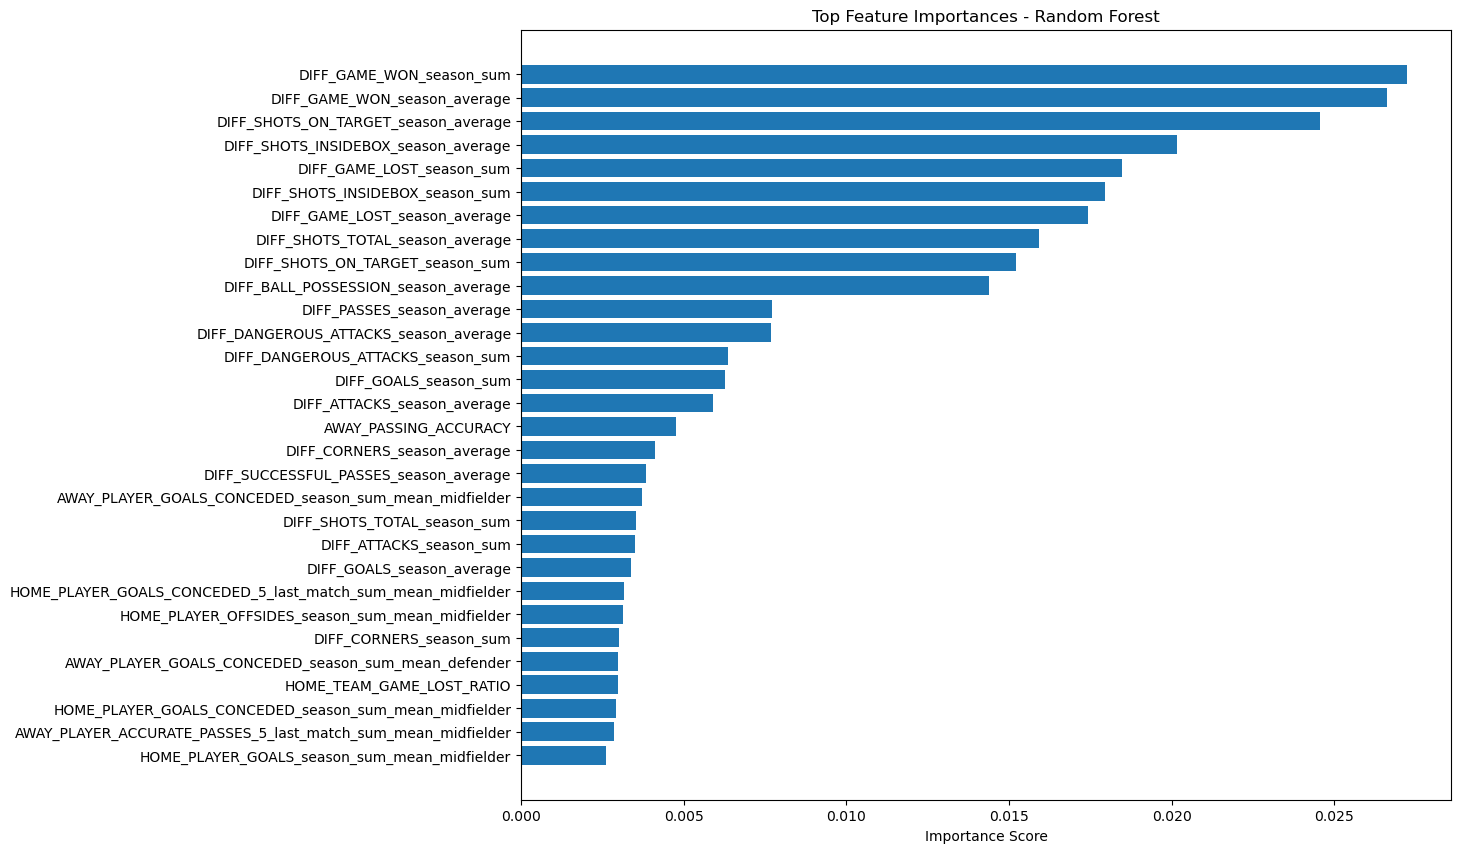

In [ ]:
feature_importances = final_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importances)[::-1]

N = 30
top_indices = indices[:N]

plt.figure(figsize=(12, 10))
plt.barh(range(N), feature_importances[top_indices], align='center')
plt.yticks(range(N), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top Feature Importances - Random Forest")
plt.show()


# Prédictions

In [ ]:
y_sub = final_model.predict(sub_data)

In [ ]:
# Reconstruction du DataFrame y_sub avec les colonnes 'HOME_WINS', 'DRAW', 'AWAY_WINS'
y_sub_df = pd.DataFrame(y_sub, columns=['PRED'])

# Transformation en one-hot encoding pour obtenir les 3 colonnes
y_sub_df['HOME_WINS'] = (y_sub_df['PRED'] == 0).astype(int)
y_sub_df['DRAW'] = (y_sub_df['PRED'] == 1).astype(int)
y_sub_df['AWAY_WINS'] = (y_sub_df['PRED'] == 2).astype(int)

# Ajout de la colonne 'ID' depuis sub_data
y_sub_df['ID'] = sub_data.index

# Suppression de la colonne 'PRED'
y_sub_df.drop('PRED', axis=1, inplace=True)

# Réorganiser les colonnes pour avoir 'ID' en premier
y_sub_df = y_sub_df[['ID', 'HOME_WINS', 'DRAW', 'AWAY_WINS']]

# Afficher les premières lignes du résultat final
y_sub_df = y_sub_df.set_index('ID')
y_sub_df.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
12303.0,1,0,0
12304.0,1,0,0
12305.0,1,0,0
12306.0,1,0,0
12307.0,1,0,0


In [ ]:
y_sub_df.to_csv('../data/Sub_Data/5_sub_scores.csv')